# NOAA Storms Forecasting

Predict how the intensity of storms changes over time. Let's build a couple model here and compare them to the performance of other models in literature.

The data used for this analysis will be from: https://catalog.data.gov/dataset/ncdc-storm-events-database

In [1]:
# Basic Utilities
import pandas as pd
import numpy as np
import glob

# Visualization 
import seaborn as sb
import matplotlib.pyplot as plt
import folium

# Database
from influxdb import DataFrameClient

# notebook properties
%matplotlib inline
pd.set_option('display.max_columns', 500)
sb.set(rc={'figure.figsize':(11,7)})

## Data Preparation
Load in the storms database and get a feel for what is in it and what types of fields we can use for modeling. This section is for the highest level inspection of features within the dataset

In [2]:
storm_data_files = glob.glob("NOAA-Storm-Data/StormEvents*.gz")
storm_data_files[:5]

['NOAA-Storm-Data\\StormEvents_details-ftp_v1.0_d1950_c20170120.csv.gz',
 'NOAA-Storm-Data\\StormEvents_details-ftp_v1.0_d1951_c20160223.csv.gz',
 'NOAA-Storm-Data\\StormEvents_details-ftp_v1.0_d1952_c20170619.csv.gz',
 'NOAA-Storm-Data\\StormEvents_details-ftp_v1.0_d1953_c20160223.csv.gz',
 'NOAA-Storm-Data\\StormEvents_details-ftp_v1.0_d1954_c20160223.csv.gz']

In [3]:
storm_data = pd.concat([pd.read_csv(x, compression='gzip') for x in storm_data_files])
storm_data.head()

C:\Users\Brandon\Anaconda3\envs\databases\lib\site-packages\IPython\core\interactiveshell.py:3337: DtypeWarning: Columns (26,28) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\Brandon\Anaconda3\envs\databases\lib\site-packages\IPython\core\interactiveshell.py:3337: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\Brandon\Anaconda3\envs\databases\lib\site-packages\IPython\core\interactiveshell.py:3337: DtypeWarning: Columns (29,34,35,37) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,FAT_YEARMONTH,FAT_DAY,FAT_TIME,FATALITY_ID,FATALITY_TYPE,FATALITY_DATE,FATALITY_AGE,FATALITY_SEX,FATALITY_LOCATION,EVENT_YEARMONTH,YEARMONTH,LOCATION_INDEX,RANGE,AZIMUTH,LOCATION,LATITUDE,LONGITUDE,LAT2,LON2
0,195004.0,28.0,1445.0,195004.0,28.0,1445.0,NaN,10096222,OKLAHOMA,40.0,1950.0,April,Tornado,C,149.0,WASHITA,NaN,28-APR-50 14:45:00,CST,28-APR-50 14:45:00,0.0,0.0,0.0,0.0,250K,0,NaN,0.0,NaN,NaN,NaN,F3,3.4,400.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,35.12,-99.20,35.17,-99.20,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,195004.0,29.0,1530.0,195004.0,29.0,1530.0,NaN,10120412,TEXAS,48.0,1950.0,April,Tornado,C,93.0,COMANCHE,NaN,29-APR-50 15:30:00,CST,29-APR-50 15:30:00,0.0,0.0,0.0,0.0,25K,0,NaN,0.0,NaN,NaN,NaN,F1,11.5,200.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,31.90,-98.60,31.73,-98.60,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,195007.0,5.0,1800.0,195007.0,5.0,1800.0,NaN,10104927,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,77.0,LEHIGH,NaN,05-JUL-50 18:00:00,CST,05-JUL-50 18:00:00,2.0,0.0,0.0,0.0,25K,0,NaN,0.0,NaN,NaN,NaN,F2,12.9,33.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,40.58,-75.70,40.65,-75.47,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,195007.0,5.0,1830.0,195007.0,5.0,1830.0,NaN,10104928,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,43.0,DAUPHIN,NaN,05-JUL-50 18:30:00,CST,05-JUL-50 18:30:00,0.0,0.0,0.0,0.0,2.5K,0,NaN,0.0,NaN,NaN,NaN,F2,0.0,13.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,40.60,-76.75,NaN,NaN,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,195007.0,24.0,1440.0,195007.0,24.0,1440.0,NaN,10104929,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,39.0,CRAWFORD,NaN,24-JUL-50 14:40:00,CST,24-JUL-50 14:40:00,0.0,0.0,0.0,0.0,2.5K,0,NaN,0.0,NaN,NaN,NaN,F0,0.0,33.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,41.63,-79.68,NaN,NaN,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Capture the rogue files that weren't compressed with gzip..
non_gzip_files = glob.glob("NOAA-Storm-Data/StormEvents*.csv")
non_gzip_files

['NOAA-Storm-Data\\StormEvents_locations-ftp_v1.0_d2000_c20200707.csv']

In [5]:
non_gzip_data = pd.concat([pd.read_csv(x) for x in non_gzip_files])
storm_data = pd.concat([storm_data, non_gzip_data])
storm_data.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,FAT_YEARMONTH,FAT_DAY,FAT_TIME,FATALITY_ID,FATALITY_TYPE,FATALITY_DATE,FATALITY_AGE,FATALITY_SEX,FATALITY_LOCATION,EVENT_YEARMONTH,YEARMONTH,LOCATION_INDEX,RANGE,AZIMUTH,LOCATION,LATITUDE,LONGITUDE,LAT2,LON2
0,195004.0,28.0,1445.0,195004.0,28.0,1445.0,NaN,10096222,OKLAHOMA,40.0,1950.0,April,Tornado,C,149.0,WASHITA,NaN,28-APR-50 14:45:00,CST,28-APR-50 14:45:00,0.0,0.0,0.0,0.0,250K,0,NaN,0.0,NaN,NaN,NaN,F3,3.4,400.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,35.12,-99.20,35.17,-99.20,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,195004.0,29.0,1530.0,195004.0,29.0,1530.0,NaN,10120412,TEXAS,48.0,1950.0,April,Tornado,C,93.0,COMANCHE,NaN,29-APR-50 15:30:00,CST,29-APR-50 15:30:00,0.0,0.0,0.0,0.0,25K,0,NaN,0.0,NaN,NaN,NaN,F1,11.5,200.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,31.90,-98.60,31.73,-98.60,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,195007.0,5.0,1800.0,195007.0,5.0,1800.0,NaN,10104927,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,77.0,LEHIGH,NaN,05-JUL-50 18:00:00,CST,05-JUL-50 18:00:00,2.0,0.0,0.0,0.0,25K,0,NaN,0.0,NaN,NaN,NaN,F2,12.9,33.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,40.58,-75.70,40.65,-75.47,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,195007.0,5.0,1830.0,195007.0,5.0,1830.0,NaN,10104928,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,43.0,DAUPHIN,NaN,05-JUL-50 18:30:00,CST,05-JUL-50 18:30:00,0.0,0.0,0.0,0.0,2.5K,0,NaN,0.0,NaN,NaN,NaN,F2,0.0,13.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,40.60,-76.75,NaN,NaN,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,195007.0,24.0,1440.0,195007.0,24.0,1440.0,NaN,10104929,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,39.0,CRAWFORD,NaN,24-JUL-50 14:40:00,CST,24-JUL-50 14:40:00,0.0,0.0,0.0,0.0,2.5K,0,NaN,0.0,NaN,NaN,NaN,F0,0.0,33.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,41.63,-79.68,NaN,NaN,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Assessing Timeseries Missingness
Downselect to the data that at least has a timestamp.

In [6]:
n_observations = len(storm_data.index)
n_missing_begin_timestamps = sum(storm_data['BEGIN_DATE_TIME'].isna())
n_missing_end_timestamps = sum(storm_data['END_DATE_TIME'].isna())

print("{} of {} rows have a missing start timestamp - {:.2f}% missingness"\
      .format(n_missing_begin_timestamps, n_observations, 100 * n_missing_begin_timestamps / n_observations))
print("{} of {} rows have a missing end timestamp - {:.2f}% missingness"\
      .format(n_missing_end_timestamps, n_observations, 100 * n_missing_end_timestamps / n_observations))

1398963 of 3032660 rows have a missing start timestamp - 46.13% missingness
1398963 of 3032660 rows have a missing end timestamp - 46.13% missingness


That's almost half of the data... At least we are consistent with the number of observations with a missing timestamp. Let's see if the old-fashioned timestamp was used more frequently. This may be a case where the newer `DateTime` datatype wasn't implemented until a certain year

In [7]:
# Find the missingness for the year/month column
n_missing_begin_simple_yearmo = sum(storm_data['BEGIN_YEARMONTH'].isna())
n_missing_end_simple_yearmo = sum(storm_data['END_YEARMONTH'].isna())

# Missingnes for the day column
n_missing_begin_simple_day = sum(storm_data['BEGIN_DAY'].isna())
n_missing_end_simple_day = sum(storm_data['END_DAY'].isna())

# Missingness for the time column
n_missing_begin_simple_times = sum(storm_data['BEGIN_TIME'].isna())
n_missing_end_simple_times = sum(storm_data['END_TIME'].isna())

# Let's take a look at the percentage of missingness
print("{} of {} rows have a missing start year-month - {:.2f}% missingness"\
      .format(n_missing_begin_simple_yearmo, n_observations, 100 * n_missing_begin_simple_yearmo / n_observations))
print("{} of {} rows have a missing end year-month - {:.2f}% missingness"\
      .format(n_missing_end_simple_yearmo, n_observations, 100 * n_missing_end_simple_yearmo / n_observations))
print("{} of {} rows have a missing start year-month - {:.2f}% missingness"\
      .format(n_missing_begin_simple_day, n_observations, 100 * n_missing_begin_simple_day / n_observations))
print("{} of {} rows have a missing end year-month - {:.2f}% missingness"\
      .format(n_missing_end_simple_day, n_observations, 100 * n_missing_end_simple_day / n_observations))
print("{} of {} rows have a missing start year-month - {:.2f}% missingness"\
      .format(n_missing_begin_simple_times, n_observations, 100 * n_missing_begin_simple_times / n_observations))
print("{} of {} rows have a missing end year-month - {:.2f}% missingness"\
      .format(n_missing_end_simple_times, n_observations, 100 * n_missing_end_simple_times / n_observations))

1398963 of 3032660 rows have a missing start year-month - 46.13% missingness
1398963 of 3032660 rows have a missing end year-month - 46.13% missingness
1398963 of 3032660 rows have a missing start year-month - 46.13% missingness
1398963 of 3032660 rows have a missing end year-month - 46.13% missingness
1398963 of 3032660 rows have a missing start year-month - 46.13% missingness
1398963 of 3032660 rows have a missing end year-month - 46.13% missingness


Missingness is pretty consistent across the board. It looks like we truly have roughly half of our data without datetimes. Continue researching this on the NOAA website to see if there is a way to impute the missing datetimes for these eventIDs

In [8]:
available_storm_data = storm_data[~storm_data['BEGIN_YEARMONTH'].isna()].copy()
available_storm_data.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,FAT_YEARMONTH,FAT_DAY,FAT_TIME,FATALITY_ID,FATALITY_TYPE,FATALITY_DATE,FATALITY_AGE,FATALITY_SEX,FATALITY_LOCATION,EVENT_YEARMONTH,YEARMONTH,LOCATION_INDEX,RANGE,AZIMUTH,LOCATION,LATITUDE,LONGITUDE,LAT2,LON2
0,195004.0,28.0,1445.0,195004.0,28.0,1445.0,NaN,10096222,OKLAHOMA,40.0,1950.0,April,Tornado,C,149.0,WASHITA,NaN,28-APR-50 14:45:00,CST,28-APR-50 14:45:00,0.0,0.0,0.0,0.0,250K,0,NaN,0.0,NaN,NaN,NaN,F3,3.4,400.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,35.12,-99.20,35.17,-99.20,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,195004.0,29.0,1530.0,195004.0,29.0,1530.0,NaN,10120412,TEXAS,48.0,1950.0,April,Tornado,C,93.0,COMANCHE,NaN,29-APR-50 15:30:00,CST,29-APR-50 15:30:00,0.0,0.0,0.0,0.0,25K,0,NaN,0.0,NaN,NaN,NaN,F1,11.5,200.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,31.90,-98.60,31.73,-98.60,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,195007.0,5.0,1800.0,195007.0,5.0,1800.0,NaN,10104927,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,77.0,LEHIGH,NaN,05-JUL-50 18:00:00,CST,05-JUL-50 18:00:00,2.0,0.0,0.0,0.0,25K,0,NaN,0.0,NaN,NaN,NaN,F2,12.9,33.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,40.58,-75.70,40.65,-75.47,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,195007.0,5.0,1830.0,195007.0,5.0,1830.0,NaN,10104928,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,43.0,DAUPHIN,NaN,05-JUL-50 18:30:00,CST,05-JUL-50 18:30:00,0.0,0.0,0.0,0.0,2.5K,0,NaN,0.0,NaN,NaN,NaN,F2,0.0,13.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,40.60,-76.75,NaN,NaN,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,195007.0,24.0,1440.0,195007.0,24.0,1440.0,NaN,10104929,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,39.0,CRAWFORD,NaN,24-JUL-50 14:40:00,CST,24-JUL-50 14:40:00,0.0,0.0,0.0,0.0,2.5K,0,NaN,0.0,NaN,NaN,NaN,F0,0.0,33.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,41.63,-79.68,NaN,NaN,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Fixing the Datetimes

The datetimes are in a slightly ambiguous format. Let's reformat them so we explicitly know the year (19XX or 20XX) before converting to a pandas datetime type. 

In [9]:
def prepare_year(date_string):
    """
    Given the last two digits representing the year '20 or '66, impute the beginning of the year string to
    complete the representation as '2020' or '1966'
    
    """

    year_suffix = int(date_string.split("-")[2].split(" ")[0])
    
    if year_suffix < 50:
        formatted_year = "20{}".format(year_suffix)
    else:
        formatted_year = "19{}".format(year_suffix)
        
    # reconstruct the datetime
    date_time_array = date_string.split(" ")
    date_components = date_time_array[0].split("-")
    
    # checking if the year is even correct...
    if len(formatted_year) == 4:
        reconstructed_datetime = "{}-{}-{} {}".format(date_components[0], date_components[1], formatted_year, date_time_array[1])
    else:
        reconstructed_datetime = np.NaN
    return reconstructed_datetime

In [10]:
# Fix the date-times
available_storm_data['BEGIN_DATE_TIME_REVAMP'] = pd.to_datetime(
    available_storm_data['BEGIN_DATE_TIME'].apply(prepare_year), format="%d-%b-%Y %X")
available_storm_data['END_DATE_TIME_REVAMP'] = pd.to_datetime(
    available_storm_data['END_DATE_TIME'].apply(prepare_year), format="%d-%b-%Y %X")

In [11]:
available_storm_data.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,FAT_YEARMONTH,FAT_DAY,FAT_TIME,FATALITY_ID,FATALITY_TYPE,FATALITY_DATE,FATALITY_AGE,FATALITY_SEX,FATALITY_LOCATION,EVENT_YEARMONTH,YEARMONTH,LOCATION_INDEX,RANGE,AZIMUTH,LOCATION,LATITUDE,LONGITUDE,LAT2,LON2,BEGIN_DATE_TIME_REVAMP,END_DATE_TIME_REVAMP
0,195004.0,28.0,1445.0,195004.0,28.0,1445.0,NaN,10096222,OKLAHOMA,40.0,1950.0,April,Tornado,C,149.0,WASHITA,NaN,28-APR-50 14:45:00,CST,28-APR-50 14:45:00,0.0,0.0,0.0,0.0,250K,0,NaN,0.0,NaN,NaN,NaN,F3,3.4,400.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,35.12,-99.20,35.17,-99.20,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-04-28 14:45:00,1950-04-28 14:45:00
1,195004.0,29.0,1530.0,195004.0,29.0,1530.0,NaN,10120412,TEXAS,48.0,1950.0,April,Tornado,C,93.0,COMANCHE,NaN,29-APR-50 15:30:00,CST,29-APR-50 15:30:00,0.0,0.0,0.0,0.0,25K,0,NaN,0.0,NaN,NaN,NaN,F1,11.5,200.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,31.90,-98.60,31.73,-98.60,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-04-29 15:30:00,1950-04-29 15:30:00
2,195007.0,5.0,1800.0,195007.0,5.0,1800.0,NaN,10104927,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,77.0,LEHIGH,NaN,05-JUL-50 18:00:00,CST,05-JUL-50 18:00:00,2.0,0.0,0.0,0.0,25K,0,NaN,0.0,NaN,NaN,NaN,F2,12.9,33.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,40.58,-75.70,40.65,-75.47,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-07-05 18:00:00,1950-07-05 18:00:00
3,195007.0,5.0,1830.0,195007.0,5.0,1830.0,NaN,10104928,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,43.0,DAUPHIN,NaN,05-JUL-50 18:30:00,CST,05-JUL-50 18:30:00,0.0,0.0,0.0,0.0,2.5K,0,NaN,0.0,NaN,NaN,NaN,F2,0.0,13.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,40.60,-76.75,NaN,NaN,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-07-05 18:30:00,1950-07-05 18:30:00
4,195007.0,24.0,1440.0,195007.0,24.0,1440.0,NaN,10104929,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,39.0,CRAWFORD,NaN,24-JUL-50 14:40:00,CST,24-JUL-50 14:40:00,0.0,0.0,0.0,0.0,2.5K,0,NaN,0.0,NaN,NaN,NaN,F0,0.0,33.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,41.63,-79.68,NaN,NaN,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-07-24 14:40:00,1950-07-24 14:40:00


## Database Import
Import the content of the pandas dataframe into a timeseries optimizied database (InfluxDB). We will query directly from the database for the remainder of the notebook

In [ ]:
host='localhost'
port=8086
dbname = 'NOAA'
client = DataFrameClient(host, port, dbname)

In [ ]:
print("Creating database: " + dbname)
client.create_database(dbname)

In [ ]:
# prepare the data with a datetime index - we will use the begin-time 
available_storm_data = available_storm_data.set_index(pd.DatetimeIndex(available_storm_data['BEGIN_DATE_TIME_REVAMP']))
available_storm_data.head()

In [ ]:
print("Writing contents of DataFrame to DB")
client.write_points(available_storm_data, 'storms')

In [ ]:
print("Read DataFrame")
    client.query("select * from demo")

In [ ]:
client.close()

## EDA
Using the data, create some visualizations to explore the different features

In [12]:
available_storm_data.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,FAT_YEARMONTH,FAT_DAY,FAT_TIME,FATALITY_ID,FATALITY_TYPE,FATALITY_DATE,FATALITY_AGE,FATALITY_SEX,FATALITY_LOCATION,EVENT_YEARMONTH,YEARMONTH,LOCATION_INDEX,RANGE,AZIMUTH,LOCATION,LATITUDE,LONGITUDE,LAT2,LON2,BEGIN_DATE_TIME_REVAMP,END_DATE_TIME_REVAMP
0,195004.0,28.0,1445.0,195004.0,28.0,1445.0,NaN,10096222,OKLAHOMA,40.0,1950.0,April,Tornado,C,149.0,WASHITA,NaN,28-APR-50 14:45:00,CST,28-APR-50 14:45:00,0.0,0.0,0.0,0.0,250K,0,NaN,0.0,NaN,NaN,NaN,F3,3.4,400.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,35.12,-99.20,35.17,-99.20,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-04-28 14:45:00,1950-04-28 14:45:00
1,195004.0,29.0,1530.0,195004.0,29.0,1530.0,NaN,10120412,TEXAS,48.0,1950.0,April,Tornado,C,93.0,COMANCHE,NaN,29-APR-50 15:30:00,CST,29-APR-50 15:30:00,0.0,0.0,0.0,0.0,25K,0,NaN,0.0,NaN,NaN,NaN,F1,11.5,200.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,31.90,-98.60,31.73,-98.60,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-04-29 15:30:00,1950-04-29 15:30:00
2,195007.0,5.0,1800.0,195007.0,5.0,1800.0,NaN,10104927,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,77.0,LEHIGH,NaN,05-JUL-50 18:00:00,CST,05-JUL-50 18:00:00,2.0,0.0,0.0,0.0,25K,0,NaN,0.0,NaN,NaN,NaN,F2,12.9,33.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,40.58,-75.70,40.65,-75.47,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-07-05 18:00:00,1950-07-05 18:00:00
3,195007.0,5.0,1830.0,195007.0,5.0,1830.0,NaN,10104928,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,43.0,DAUPHIN,NaN,05-JUL-50 18:30:00,CST,05-JUL-50 18:30:00,0.0,0.0,0.0,0.0,2.5K,0,NaN,0.0,NaN,NaN,NaN,F2,0.0,13.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,40.60,-76.75,NaN,NaN,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-07-05 18:30:00,1950-07-05 18:30:00
4,195007.0,24.0,1440.0,195007.0,24.0,1440.0,NaN,10104929,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,39.0,CRAWFORD,NaN,24-JUL-50 14:40:00,CST,24-JUL-50 14:40:00,0.0,0.0,0.0,0.0,2.5K,0,NaN,0.0,NaN,NaN,NaN,F0,0.0,33.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,41.63,-79.68,NaN,NaN,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-07-24 14:40:00,1950-07-24 14:40:00


Let's take a look at the different storm event types that are available

In [40]:
available_storm_data['EVENT_TYPE'].unique()

array(['Tornado', 'Hail', 'Thunderstorm Wind',
       'TORNADOES, TSTM WIND, HAIL', 'THUNDERSTORM WINDS/FLOODING',
       'HAIL/ICY ROADS', 'HAIL FLOODING',
       'THUNDERSTORM WINDS/FLASH FLOOD', 'THUNDERSTORM WINDS LIGHTNING',
       'THUNDERSTORM WIND/ TREES', 'THUNDERSTORM WIND/ TREE',
       'THUNDERSTORM WINDS FUNNEL CLOU', 'TORNADO/WATERSPOUT',
       'THUNDERSTORM WINDS/HEAVY RAIN', 'THUNDERSTORM WINDS HEAVY RAIN',
       'THUNDERSTORM WINDS/ FLOOD', 'High Wind', 'Flash Flood',
       'Winter Storm', 'Blizzard', 'Cold/Wind Chill', 'Heavy Snow',
       'Flood', 'Ice Storm', 'Dense Fog', 'Winter Weather', 'Avalanche',
       'Frost/Freeze', 'Lightning', 'Heat', 'Heavy Rain', 'Funnel Cloud',
       'Coastal Flood', 'Strong Wind', 'Wildfire', 'Waterspout',
       'High Surf', 'Dust Storm', 'Drought', 'Rip Current', 'Dust Devil',
       'Tropical Storm', 'Debris Flow', 'Hurricane (Typhoon)',
       'Freezing Fog', 'Storm Surge/Tide', 'Marine High Wind', 'Sleet',
       'Lake-Effect

In [12]:
# Let's only focus on hurricanes or tornados - we are looking for all observations
hurricanes = available_storm_data[available_storm_data['EVENT_TYPE'].isin([
    'Hurricane', 'Hurricane (Typhoon)','Marine Hurricane/Typhoon', 'Tornado', 'TORNADOES, TSTM WIND, HAIL',
'TORNADO/WATERSPOUT',])]
hurricanes

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,FAT_YEARMONTH,FAT_DAY,FAT_TIME,FATALITY_ID,FATALITY_TYPE,FATALITY_DATE,FATALITY_AGE,FATALITY_SEX,FATALITY_LOCATION,EVENT_YEARMONTH,YEARMONTH,LOCATION_INDEX,RANGE,AZIMUTH,LOCATION,LATITUDE,LONGITUDE,LAT2,LON2,BEGIN_DATE_TIME_REVAMP,END_DATE_TIME_REVAMP
0,195004.0,28.0,1445.0,195004.0,28.0,1445.0,NaN,10096222,OKLAHOMA,40.0,1950.0,April,Tornado,C,149.0,WASHITA,NaN,28-APR-50 14:45:00,CST,28-APR-50 14:45:00,0.0,0.0,0.0,0.0,250K,0,NaN,0.0,NaN,NaN,NaN,F3,3.40,400.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,35.1200,-99.2000,35.1700,-99.2000,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-04-28 14:45:00,1950-04-28 14:45:00
1,195004.0,29.0,1530.0,195004.0,29.0,1530.0,NaN,10120412,TEXAS,48.0,1950.0,April,Tornado,C,93.0,COMANCHE,NaN,29-APR-50 15:30:00,CST,29-APR-50 15:30:00,0.0,0.0,0.0,0.0,25K,0,NaN,0.0,NaN,NaN,NaN,F1,11.50,200.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,31.9000,-98.6000,31.7300,-98.6000,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-04-29 15:30:00,1950-04-29 15:30:00
2,195007.0,5.0,1800.0,195007.0,5.0,1800.0,NaN,10104927,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,77.0,LEHIGH,NaN,05-JUL-50 18:00:00,CST,05-JUL-50 18:00:00,2.0,0.0,0.0,0.0,25K,0,NaN,0.0,NaN,NaN,NaN,F2,12.90,33.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,40.5800,-75.7000,40.6500,-75.4700,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-07-05 18:00:00,1950-07-05 18:00:00
3,195007.0,5.0,1830.0,195007.0,5.0,1830.0,NaN,10104928,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,43.0,DAUPHIN,NaN,05-JUL-50 18:30:00,CST,05-JUL-50 18:30:00,0.0,0.0,0.0,0.0,2.5K,0,NaN,0.0,NaN,NaN,NaN,F2,0.00,13.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,40.6000,-76.7500,NaN,NaN,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-07-05 18:30:00,1950-07-05 18:30:00
4,195007.0,24.0,1440.0,195007.0,24.0,1440.0,NaN,10104929,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,39.0,CRAWFORD,NaN,24-JUL-50 14:40:00,CST,24-JUL-50 14:40:00,0.0,0.0,0.0,0.0,2.5K,0,NaN,0.0,NaN,NaN,NaN,F0,0.00,33.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,41.6300,-79.6800,NaN,NaN,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-07-24 14:40:00,1950-07-24 14:40:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31173,202006.0,4.0,159.0,202006.0,4.0,200.0,148826.0,896594,MISSOURI,29.0,2020.0,June,Tornado,C,13.0,BATES,EAX,04-JUN-20 01:59:00,CST-6,04-JUN-20 02:00:00,0.0,0.0,0.0,0.0,NaN,NaN,Emergency Manager,NaN,NaN,NaN,NaN,EF0,0.63,40.0,NaN,NaN,NaN,NaN,3.0,NNE,CRESCENT HILL,3.0,NNE,CRESCENT HILL,38.4719,-94.3316,38.4658,-94.3229,Two rounds of severe storms came through the K...,This is a continuation of the brief QLCS mesov...,CSV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-06-04 01:59:00,2020-06-04 02:00:00
31289,202006.0,28.0,1954.0,202006.0,28.0,1956.0,149511.0,901206,MINNESOTA,27.0,2020.0,June,Tornado,C,169.0,WINONA,ARX,28-JUN-20 19:54:00,CST-6,28-JUN-20 19:56:00,0.0,0.0,0.0,0.0,2.00K,0.00K,Public,NaN,NaN,NaN,NaN,EF0,0.61,20.0,NaN,NaN,NaN,NaN,2.0,E,STOCKTON,2.0,S

### Storm Intensities

Understand the distribution that we are working with.

In [14]:
na_filled_hurricane_categories = hurricanes['TOR_F_SCALE'].fillna(-1)
intensity_counts = na_filled_hurricane_categories.value_counts()
intensity_counts

F0     20769
F1     16923
EF0     9685
F2      9022
EF1     6460
-1      3948
F3      2897
EF2     1809
F4       999
EF3      514
EFU      386
F5       124
EF4      114
EF5       14
Name: TOR_F_SCALE, dtype: int64

Text(0, 0.5, 'Number of Occurrences')

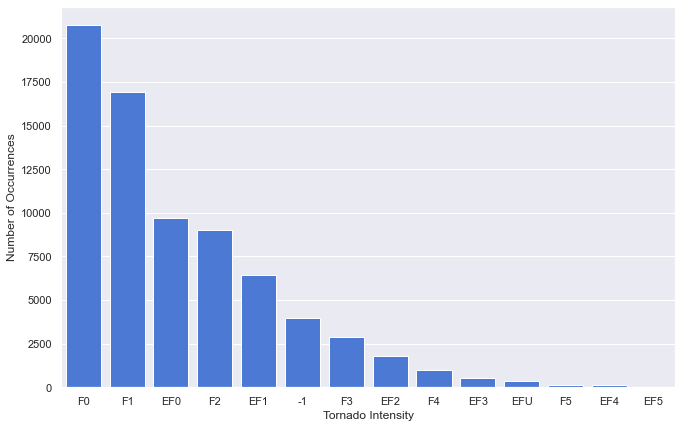

In [15]:
# Create the plot to visualize this information
ax = sb.barplot(x=intensity_counts.index, y=intensity_counts, color="#3471eb")
ax.set_xlabel("Tornado Intensity")
ax.set_ylabel("Number of Occurrences")

### Hurricane Landfall inspection


In [31]:
# prepare the coordinates of the hurricane starting locations
hurricanes.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,FAT_YEARMONTH,FAT_DAY,FAT_TIME,FATALITY_ID,FATALITY_TYPE,FATALITY_DATE,FATALITY_AGE,FATALITY_SEX,FATALITY_LOCATION,EVENT_YEARMONTH,YEARMONTH,LOCATION_INDEX,RANGE,AZIMUTH,LOCATION,LATITUDE,LONGITUDE,LAT2,LON2,BEGIN_DATE_TIME_REVAMP,END_DATE_TIME_REVAMP
11817,199607.0,11.0,2200.0,199607.0,12.0,800.0,2037283.0,5552060,GEORGIA,13.0,1996.0,July,Hurricane (Typhoon),Z,141.0,COASTAL MCINTOSH,CHS,11-JUL-96 22:00:00,EST,12-JUL-96 08:00:00,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hurricane Watch for Bertha and later a Warning...,NaN,PDC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1996-07-11 22:00:00,1996-07-12 08:00:00
12302,199607.0,11.0,2200.0,199607.0,12.0,800.0,2037283.0,5552058,GEORGIA,13.0,1996.0,July,Hurricane (Typhoon),Z,139.0,COASTAL LIBERTY,CHS,11-JUL-96 22:00:00,EST,12-JUL-96 08:00:00,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hurricane Watch for Bertha and later a Warning...,NaN,PDC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1996-07-11 22:00:00,1996-07-12 08:00:00
18673,199607.0,11.0,2200.0,199607.0,12.0,800.0,2037283.0,5552056,GEORGIA,13.0,1996.0,July,Hurricane (Typhoon),Z,119.0,COASTAL CHATHAM,CHS,11-JUL-96 22:00:00,EST,12-JUL-96 08:00:00,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hurricane Watch for Bertha and later a Warning...,NaN,PDC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1996-07-11 22:00:00,1996-07-12 08:00:00
18674,199607.0,11.0,2200.0,199607.0,12.0,800.0,2037283.0,5552057,GEORGIA,13.0,1996.0,July,Hurricane (Typhoon),Z,138.0,INLAND LIBERTY,CHS,11-JUL-96 22:00:00,EST,12-JUL-96 08:00:00,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hurricane Watch for Bertha and later a Warning...,NaN,PDC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1996-07-11 22:00:00,1996-07-12 08:00:00
18766,199607.0,12.0,100.0,199607.0,12.0,1100.0,2037282.0,5552048,SOUTH CAROLINA,45.0,1996.0,July,Hurricane (Typhoon),Z,45.0,BERKELEY,CHS,12-JUL-96 01:00:00,EST,12-JUL-96 11:00:00,0.0,0.0,0.0,0.0,NaN,NaN,NaN,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hurricane Bertha came close to the south coast...,NaN,PDC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1996-07-12 01:00:00,1996-07-12 11:00:00


In [33]:
hurricane_zones = hurricanes['CZ_NAME'].fillna(-1)
hurricane_zone_counts = hurricane_zones.value_counts()
hurricane_zone_counts

WASHINGTON                                                                                28
FRANKLIN                                                                                  17
NORTHERN MARIANAS                                                                         14
JACKSON                                                                                   14
EASTERN DARE                                                                              14
                                                                                          ..
NORTHERN TANGIPAHOA                                                                        1
NORTHERN OUTER BANKS                                                                       1
MATAGORDA SHIP CHNL TO PT ARANSAS OUT 20NM                                                 1
APALACHEE BAY OR COASTAL WATERS FROM KEATON BEACH TO OCHLOCKONEE RIVER FL OUT TO 20 NM     1
KNOX                                                                  

In [38]:
pd.DataFrame({
    "Zone-Name":hurricane_zone_counts.index,
    "Count":list(hurricane_zone_counts)
}).to_csv("zone_counts.csv",index=False)